In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import re

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style


## import model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df= pd.read_csv("../../Data and data related codes/dataset_reg.csv")

In [3]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# df

In [4]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Step 1: Filter for the last 2 months
end_date = df['Date'].max()
start_date = end_date - pd.DateOffset(months=2)
df_last_2_months = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Step 2: Prepare features (X) and target (y)
X = df_last_2_months.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
y = df_last_2_months['F_Close_pred']

# Step 3: Split the data - keep the last 1 week as an unseen test set
split_index = len(X) - 7
X_train, X_unseen_test = X[:split_index], X[split_index:]
y_train, y_unseen_test = y[:split_index], y[split_index:]

In [5]:
# Step 4: Preprocessing (StandardScaler, PowerTransformer, PCA)
# Fit scalers and PCA only on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_unseen_test_scaled = scaler.transform(X_unseen_test)

power_transformer = PowerTransformer()
X_train_transformed = power_transformer.fit_transform(X_train_scaled)
X_unseen_test_transformed = power_transformer.transform(X_unseen_test_scaled)

# Fit PCA only on the training data and apply to both train and test sets
pca = PCA(n_components=11)  # Adjust the number of components based on explained variance
X_train_pca = pca.fit_transform(X_train_transformed)
X_unseen_test_pca = pca.transform(X_unseen_test_transformed)

# Step 5: Set up parameter grid for XGBoost hyperparameter tuning
xgb_params = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.005],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# Initialize the XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# GridSearchCV with TimeSeriesSplit
xgb_cv = GridSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv)
xgb_cv.fit(X_train_pca, y_train)

# Step 6: Collect MSE and best parameters for XGBoost in a table
results = pd.DataFrame({
    'Model': ['XGBoost with PCA'],
    'Best Parameters': [xgb_cv.best_params_],
    'Best MSE': [-xgb_cv.best_score_]  # Convert negative MSE back to positive
})

# Display the table
print("Grid Search Results with MSE for XGBoost Regression with PCA:")
print(results)

# Step 7: Choose the best XGBoost model based on the lowest MSE
best_xgb_model = xgb_cv.best_estimator_
print(f"Best XGBoost model: {best_xgb_model}, MSE: {-xgb_cv.best_score_}")

# Step 8: Predict on the unseen test set
y_unseen_pred = best_xgb_model.predict(X_unseen_test_pca)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE: {mse_unseen}")


Grid Search Results with MSE for XGBoost Regression with PCA:
              Model                                    Best Parameters  \
0  XGBoost with PCA  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...   

   Best MSE  
0  0.092206  
Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), MSE: 0

In [8]:
import xgboost as xgb
print(xgb.__version__)


2.1.3


In [ ]:
results = []

# Retrieve the best model from cross-validation
best_xgb_model = xgb_cv.best_estimator_
best_mse = -xgb_cv.best_score_

# Fit the best model only on the training set to prevent leakage
best_xgb_model.fit(X_train_pca, y_train)

# Predictions on the training data
y_pred_train = best_xgb_model.predict(X_train_pca)
residuals = y_train - y_pred_train

# Calculate the sample size and sum of squared errors
n = len(y_train)  # Sample size (training data)
sse = np.sum(residuals**2)

# Approximate number of parameters for XGBoost
# Include trees and depth, considering regularization constraints in practice
p = best_xgb_model.get_params()['n_estimators'] * best_xgb_model.get_params()['max_depth']

# Avoid overestimation of `p` by considering XGBoost's internal feature selection
# Approximation: Use the effective number of leaves
# Uncomment the following block for better approximation if needed:
# p = sum(tree.get_leaf_count() for tree in best_xgb_model.get_booster().get_dump())

# Calculate AIC, BIC, and AICc
aic = n * np.log(sse / n) + 2 * p
bic = n * np.log(sse / n) + p * np.log(n)
aicc = aic + (2 * p * (p + 1)) / max(1, (n - p - 1))  # Ensure no division by zero

# Store results in a dictionary
results.append({
    'Model': 'XGBoost',
    'Best Parameters': xgb_cv.best_params_,
    'Best MSE': best_mse,
    'AIC': aic,
    'BIC': bic,
    'AICc': aicc
})

# Convert results list to DataFrame for display
results_df = pd.DataFrame(results)

# Display the table
print("Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:")
print(results_df)

Grid Search Results with MSE, AIC, BIC, and AICc for XGBoost:
     Model                                    Best Parameters  Best MSE  \
0  XGBoost  {'colsample_bytree': 0.6, 'gamma': 0, 'learnin...  0.092206   

           AIC          BIC          AICc  
0  2141.326067  4074.427562  2.884541e+06  


### Fit and predict the test set

Unseen Test MSE: 0.1253152091964826


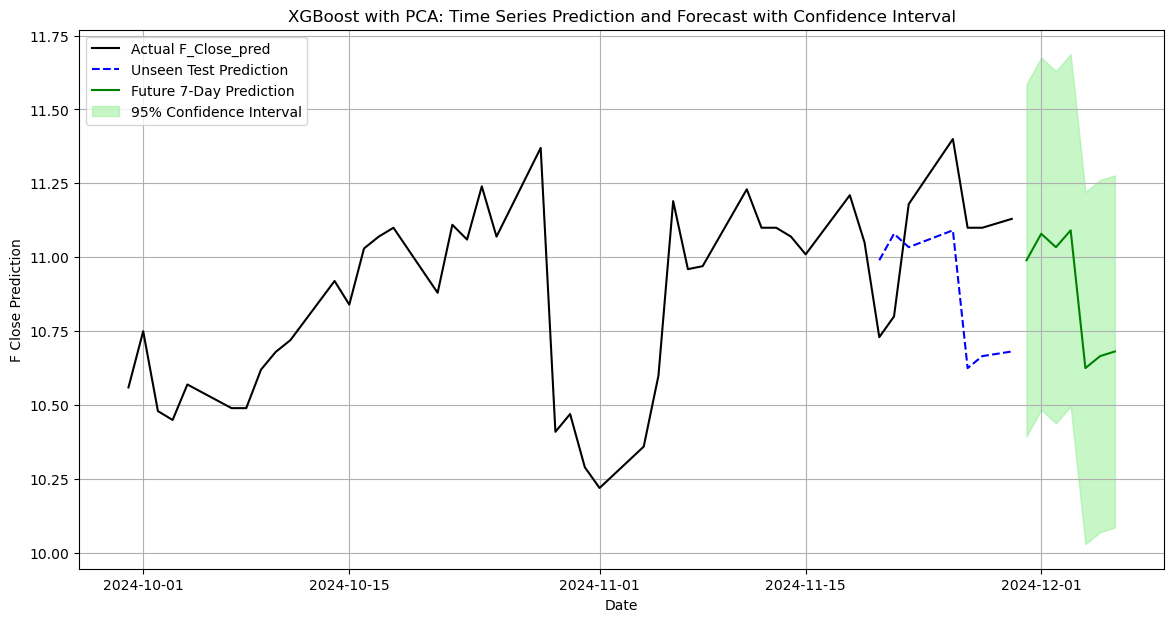

In [13]:
# Step 7: Optional: Apply early stopping manually to the best model after tuning
# Ensure X_train_val and X_unseen_test are processed correctly to prevent leakage
best_xgb_model.fit(
    X_train_pca, y_train,
    eval_set=[(X_unseen_test_pca, y_unseen_test)],
    verbose=False
)

# Step 8: Predict on the last week (unseen test data)
y_unseen_pred = best_xgb_model.predict(X_unseen_test_pca)
mse_unseen = mean_squared_error(y_unseen_test, y_unseen_pred)
print(f"Unseen Test MSE: {mse_unseen}")

# Step 9: Forecast the next 7 days with a confidence interval
# Apply preprocessing steps to future data
future_7_days = X[-7:]  # Extract the last 7 rows from the raw data
future_7_days_scaled = scaler.transform(future_7_days)  # Scale using the fitted scaler
future_7_days_transformed = power_transformer.transform(future_7_days_scaled)  # Transform using fitted transformer
future_7_days_pca = pca.transform(future_7_days_transformed)  # Apply PCA using fitted PCA

# Predict the future 7 days
future_predictions = best_xgb_model.predict(future_7_days_pca)

# Calculate confidence interval (simple approximation based on prediction standard deviation)
std_dev = np.std(y_unseen_pred - y_unseen_test)  # Residual standard deviation
upper_bound = future_predictions + (1.96 * std_dev)
lower_bound = future_predictions - (1.96 * std_dev)

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual observed values for the past 2 months
plt.plot(df_last_2_months['Date'], y, label="Actual F_Close_pred", color='black')

# Plot predictions for the unseen test data
plt.plot(
    df_last_2_months['Date'].iloc[-7:],
    y_unseen_pred,
    label="Unseen Test Prediction",
    color='blue',
    linestyle='--'
)

# Plot future forecasts
future_dates = pd.date_range(df_last_2_months['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.plot(
    future_dates,
    future_predictions,
    label="Future 7-Day Prediction",
    color='green'
)

# Add confidence intervals for the future forecast
plt.fill_between(
    future_dates,
    lower_bound,
    upper_bound,
    color='lightgreen',
    alpha=0.5,
    label="95% Confidence Interval"
)

# Add labels, title, legend, and grid
plt.xlabel("Date")
plt.ylabel("F Close Prediction")
plt.title("XGBoost with PCA: Time Series Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Assuming the necessary preprocessing and predictions (y_unseen_pred and future_predictions) are performed correctly
# using only training data prior to the test or forecast period.

# Extract dates for the last two weeks
dates_last_two_weeks = df_last_2_months['Date'].iloc[-14:]

# Extract actual values for the last two weeks
actual_values_last_two_weeks = y.iloc[-14:]

# Initialize predicted values with NaN for the first week of the two-week window
predicted_values_last_two_weeks = [np.nan] * 7 + list(y_unseen_pred)

# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Date': dates_last_two_weeks.values,
    'Actual F_Close_pred': actual_values_last_two_weeks.values,
    'Predicted F_Close_pred': predicted_values_last_two_weeks
})

# Reset index for a cleaner display
comparison_df.reset_index(drop=True, inplace=True)

# Generate future dates for the forecasted 7 days
# Ensure predictions for future data are based only on historical information (processed correctly without future leakage)
future_dates = pd.date_range(comparison_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)

# Create a DataFrame for the forecasted data with NaN for actual values and predictions in predicted column
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Actual F_Close_pred': [np.nan] * 7,  # No actual data for the future
    'Predicted F_Close_pred': list(future_predictions)  # Ensure future_predictions are based on correctly processed data
})

# Append the forecasted data to the original comparison_df
comparison_df_with_forecast = pd.concat([comparison_df, forecast_df], ignore_index=True)

# Display the updated table with both the last week's predictions and the future forecast
print(comparison_df_with_forecast)


         Date  Actual F_Close_pred  Predicted F_Close_pred
0  2024-11-11                11.23                     NaN
1  2024-11-12                11.10                     NaN
2  2024-11-13                11.10                     NaN
3  2024-11-14                11.07                     NaN
4  2024-11-15                11.01                     NaN
5  2024-11-18                11.21                     NaN
6  2024-11-19                11.05                     NaN
7  2024-11-20                10.73               10.990038
8  2024-11-21                10.80               11.079659
9  2024-11-22                11.18               11.034240
10 2024-11-25                11.40               11.091297
11 2024-11-26                11.10               10.625313
12 2024-11-27                11.10               10.665916
13 2024-11-29                11.13               10.681584
14 2024-11-30                  NaN               10.990038
15 2024-12-01                  NaN               11.0796

## Backtesting

/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Rolling Backtesting Results for XGBoost with PCA:
                Train Start                 Train End  \
0 2019-12-30 00:00:00+00:00 2020-03-25 00:00:00+00:00   
1 2020-10-14 00:00:00+00:00 2021-01-08 00:00:00+00:00   
2 2021-08-02 00:00:00+00:00 2021-10-25 00:00:00+00:00   

                 Test Start                  Test End  \
0 2020-03-26 00:00:00+00:00 2020-04-03 00:00:00+00:00   
1 2021-01-11 00:00:00+00:00 2021-01-20 00:00:00+00:00   
2 2021-10-26 00:00:00+00:00 2021-11-03 00:00:00+00:00   

                                     Best Parameters       MSE      RMSE  \
0  {'subsample': 0.8, 'n_estimators': 150, 'min_c...  3.207664  1.790995   
1  {'subsample': 0.8, 'n_estimators': 150, 'min_c...  1.296736  1.138743   
2  {'subsample': 0.8, 'n_estimators': 150, 'min_c...  8.763407  2.960305   

          R²                                        Predictions  
0 -20.128010  [6.3919034, 6.367234, 6.5647135, 6.3271084, 6....  
1  -5.601840  [8.815739, 8.906402, 8.849958, 8.867114, 

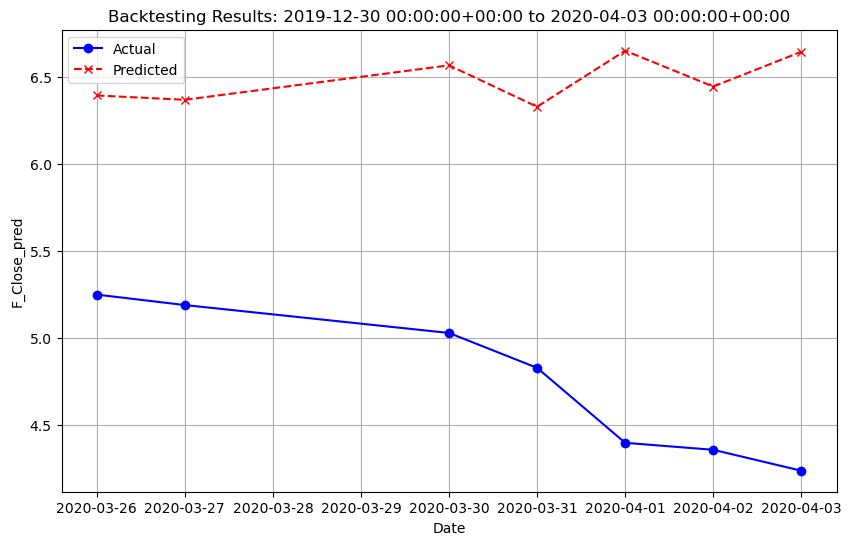

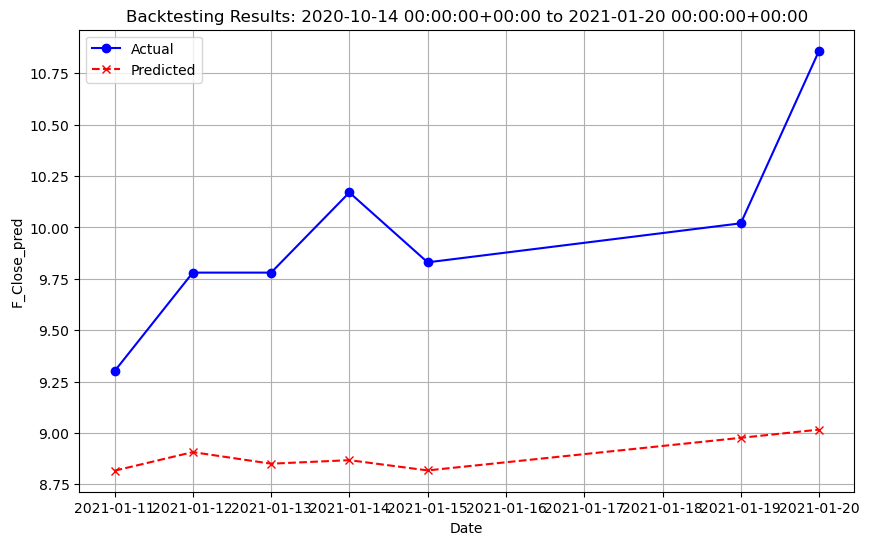

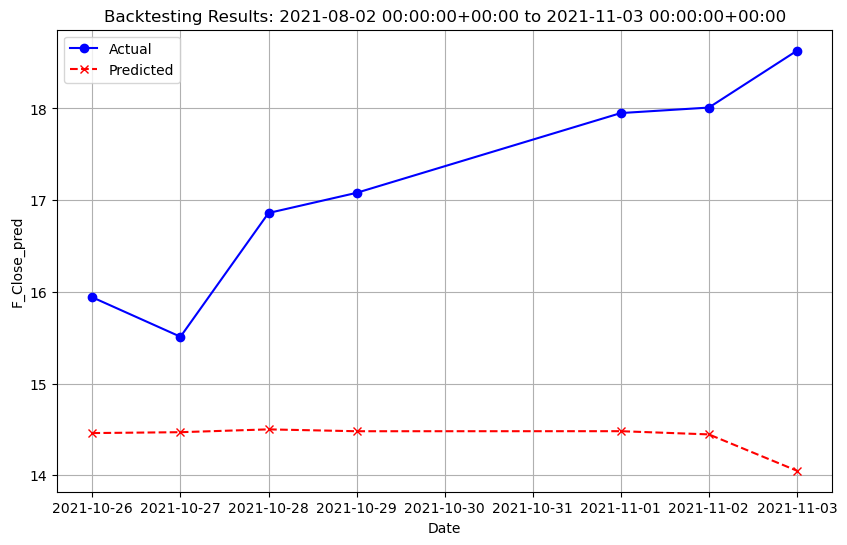

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import matplotlib.pyplot as plt

def plot_backtesting_results(backtest_results, df):
    """
    Plot fitted model predictions vs real data for each backtest.
    """
    for idx, row in backtest_results.iterrows():
        test_start = row['Test Start']
        test_end = row['Test End']

        test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]
        y_test = test_data['F_Close_pred'].values
        y_pred = row['Predictions']

        plt.figure(figsize=(10, 6))
        plt.plot(test_data['Date'], y_test, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(test_data['Date'], y_pred, label='Predicted', marker='x', linestyle='--', color='red')
        plt.title(f"Backtesting Results: {row['Train Start']} to {row['Test End']}")
        plt.xlabel('Date')
        plt.ylabel('F_Close_pred')
        plt.legend()
        plt.grid(True)
        plt.show()

def rolling_backtesting_xgboost_pca(df, num_backtests=3, window_size_months=2, test_days=7, n_pca_components=11):
    """
    Perform rolling backtesting with PCA and XGBoost-based regression models.
    """
    backtest_results = []
    start_idx = 0
    total_data_points = len(df)
    backtest_count = 0

    xgb_params = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01],
        'max_depth': [3, 4],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'gamma': [0],
        'min_child_weight': [1]
    }

    while (
        start_idx + window_size_months * 30 + test_days <= total_data_points
        and backtest_count < num_backtests
    ):
        train_start_idx = start_idx
        train_end_idx = train_start_idx + window_size_months * 30
        test_start_idx = train_end_idx
        test_end_idx = test_start_idx + test_days

        train_data = df.iloc[train_start_idx:train_end_idx]
        test_data = df.iloc[test_start_idx:test_end_idx]

        X_train = train_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_train = train_data['F_Close_pred']
        X_test = test_data.drop(columns=['Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'])
        y_test = test_data['F_Close_pred']

        scaler = StandardScaler()
        power_transformer = PowerTransformer()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_transformed = power_transformer.fit_transform(X_train_scaled)
        X_test_scaled = scaler.transform(X_test)
        X_test_transformed = power_transformer.transform(X_test_scaled)

        pca = PCA(n_components=n_pca_components)
        X_train_pca = pca.fit_transform(X_train_transformed)
        X_test_pca = pca.transform(X_test_transformed)

        xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
        tscv = TimeSeriesSplit(n_splits=3)
        xgb_cv = RandomizedSearchCV(xgb_reg, xgb_params, scoring='neg_mean_squared_error', cv=tscv, n_iter=10, random_state=42)
        xgb_cv.fit(X_train_pca, y_train)

        best_model = xgb_cv.best_estimator_
        best_model.fit(X_train_pca, y_train)

        y_pred = best_model.predict(X_test_pca)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        backtest_results.append({
            'Train Start': train_data['Date'].iloc[0],
            'Train End': train_data['Date'].iloc[-1],
            'Test Start': test_data['Date'].iloc[0],
            'Test End': test_data['Date'].iloc[-1],
            'Best Parameters': xgb_cv.best_params_,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'Predictions': y_pred
        })

        backtest_count += 1
        start_idx += 200

    return pd.DataFrame(backtest_results)

# Example usage:
# Assuming df is your DataFrame and it has columns: 'Date', 'F_Close_pred', 'F_Bollinger_Upper', 'F_Bollinger_Lower'
backtest_results_xgboost_pca = rolling_backtesting_xgboost_pca(df, num_backtests=3)

print("Rolling Backtesting Results for XGBoost with PCA:")
print(backtest_results_xgboost_pca)

plot_backtesting_results(backtest_results_xgboost_pca, df)